In [1]:
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import scipy.stats as sps
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
cov = pd.read_csv('cov.csv', parse_dates=['date'])

In [3]:
aqi = pd.read_csv('aqi.csv', parse_dates=['date'])

In [4]:
df = cov.merge(
    aqi,
    on=['province', 'date']
)

In [5]:
df['first_wave'] = df.date <= '2020-07-01'

In [6]:
DFR = None

cols = ['CO', 'NO2', 'NOx', 'O3', 'PM10', 'PM25']

min_shift = 12
max_shift = 42
res = {
    'shift': [],
    'x': [],
    'y': [],
    'fit': [],
    'R2_adj': [],
    'coeff': [],
    'standard_error': [],
    'lo': [],
    'hi': [],
    'pval': [],
}
for shift in tqdm(np.arange(min_shift, max_shift+1)):
    dfr = None
    for pr in sorted(df.province.unique()):
        _df = df[df.province==pr].set_index('date')
        _ic = _df[['incidence_trend']]
        _aq = _df[cols]
        _aq.index = _aq.index + pd.Timedelta(days=shift)
        _aq = _aq[cols]
        _dfr = _ic.merge(_aq, on='date').reset_index()
        _dfr['province'] = pr
        _dfr['first_wave'] = _dfr.date < '2020-07-01'
        
        if dfr is None:
            dfr = _dfr
        else:
            dfr = dfr.append(_dfr, ignore_index=True)
    dfr.loc[dfr.incidence_trend<=0, 'incidence_trend'] = np.nan
    for col in cols:
        dfr.loc[dfr[col]<=0, col] = np.nan
    dfr.dropna(inplace=True)
    dfr['shift'] = shift
    if DFR is None:
        DFR = dfr
    else:
        DFR = DFR.append(dfr, ignore_index=True)

    for j, x in enumerate(cols):
        mod = sm.OLS.from_formula(
            f'np.log(incidence_trend) ~ np.log({x}) + first_wave * province',
            data=dfr
        )
        _x = f"np.log({x})"
        fit = mod.fit()
        res['shift'].append(shift)
        res['x'].append(x)
        res['y'].append(np.log(dfr.incidence_trend.values))
        res['fit'].append(fit)
        res['R2_adj'].append(fit.rsquared_adj)
        res['coeff'].append(fit.params[_x])
        res['standard_error'].append(fit.bse[_x])
        conf_int = fit.conf_int(alpha=.01)
        res['lo'].append(conf_int.loc[_x, 0])
        res['hi'].append(conf_int.loc[_x, 1])
        res['pval'].append(fit.pvalues[_x])

In [7]:
res_df = pd.DataFrame(res)

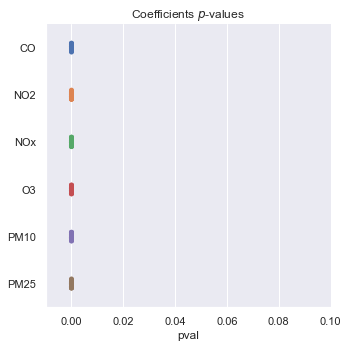

In [8]:
g = sns.catplot(
    data=res_df,
    x='pval', y='x'
)
g.axes.flat[0].set(
    title='Coefficients $p$-values',
    ylabel=None,
    xlim=(-.01, .1)
)
g.fig.tight_layout()
g.fig.savefig('images/coefficients_pvalues.png')
plt.show()

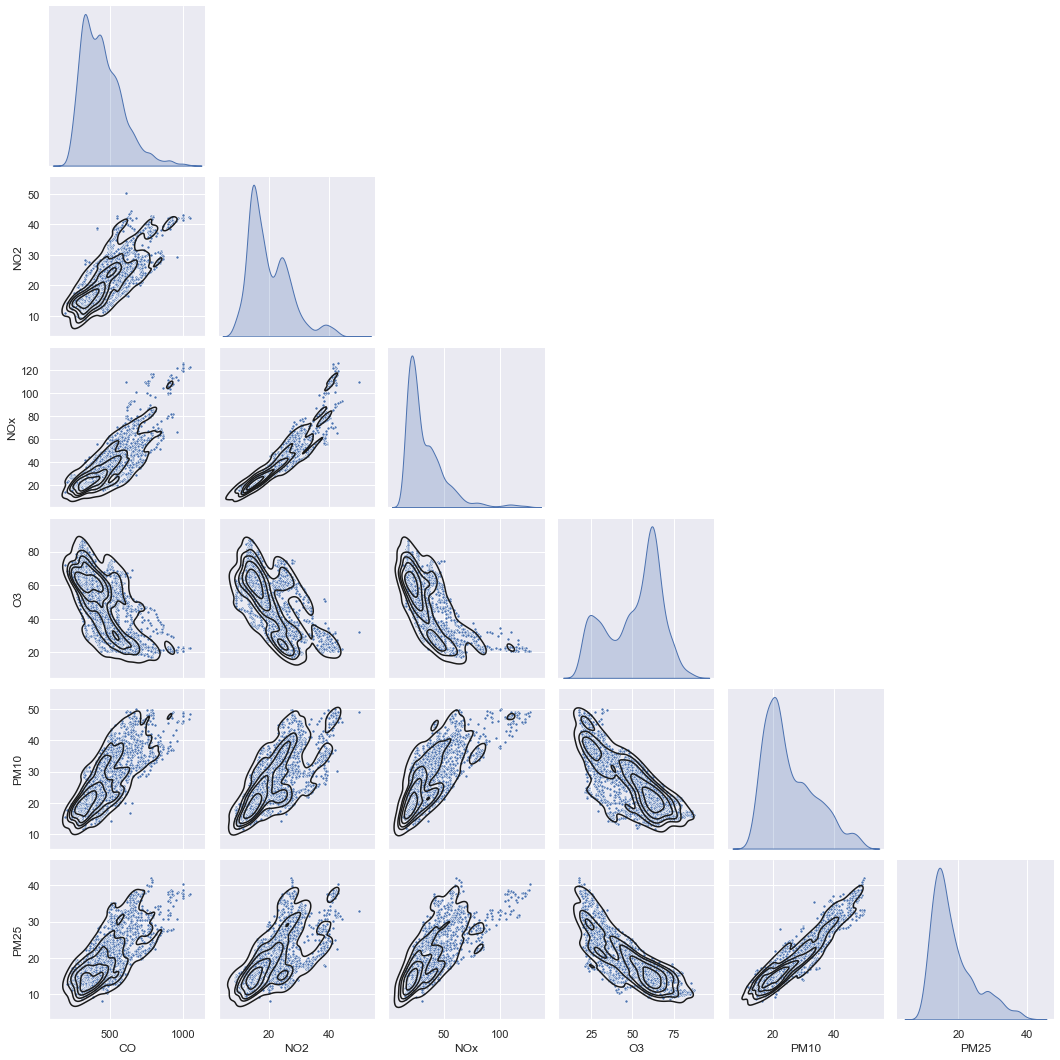

In [9]:
g = sns.pairplot(
    diag_kind="kde",
    data=df[cols],
    corner=True,
    plot_kws=dict(marker=".", lw=.2),
)
g.map_lower(sns.kdeplot, levels=6, color=".1")
g.fig.savefig('images/features_pairplot.png')
plt.show()

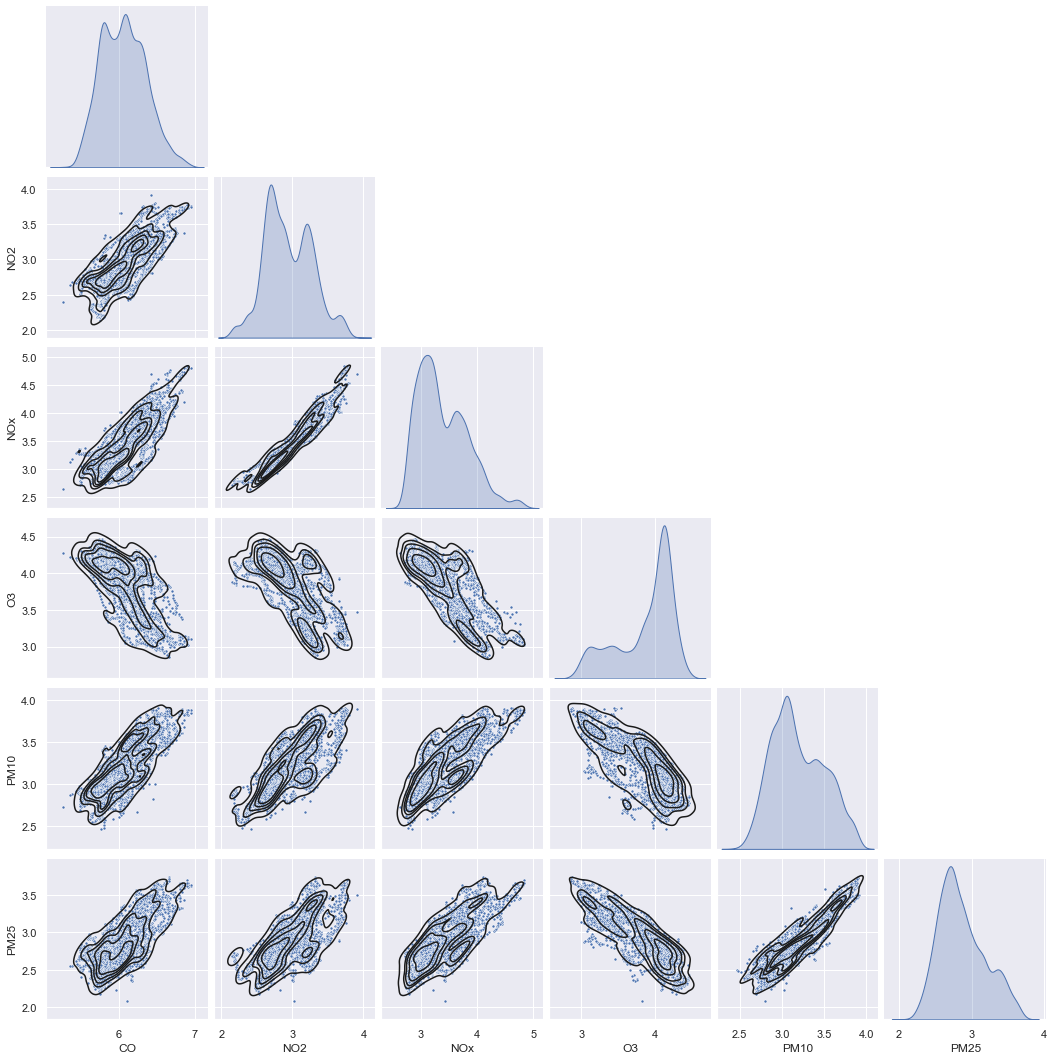

In [10]:
g = sns.pairplot(
    diag_kind="kde",
    data=np.log(df[cols]),
    corner=True,
    plot_kws=dict(marker=".", lw=.2),
)
g.map_lower(sns.kdeplot, levels=6, color=".1")
g.fig.savefig('images/features_log_pairplot.png')
plt.show()

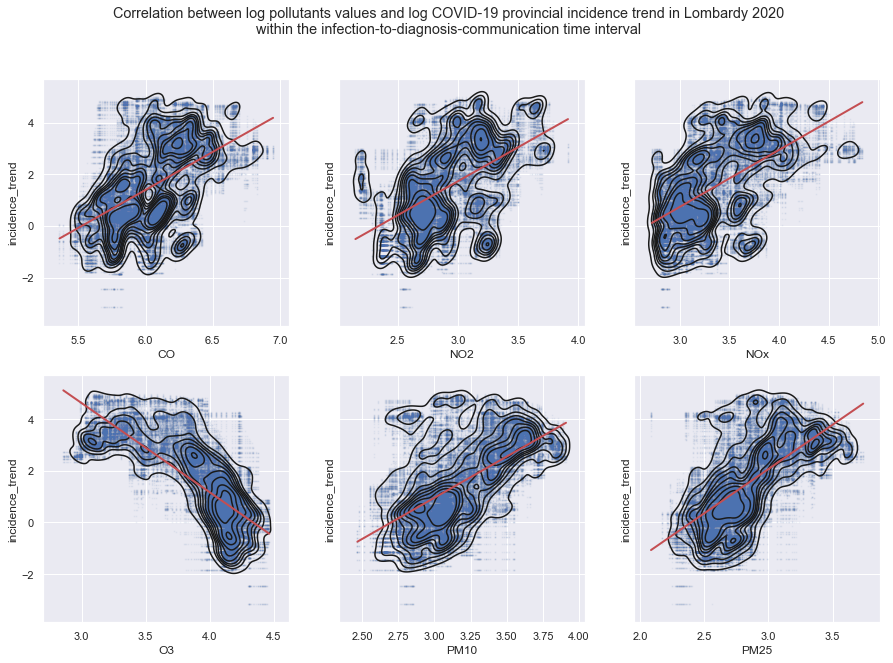

In [11]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10), sharey=True)
for i, x in enumerate(tqdm(cols)):
    ax = axs.flat[i]
    sns.regplot(
        data=np.log(DFR[['incidence_trend', x]]),
        x=x, y='incidence_trend',
        ci=None,
        ax=ax,
        line_kws=dict(color='r', lw=2),
        scatter_kws=dict(marker='.', s=1, alpha=.05)
    )
    sns.kdeplot(
        data=np.log(DFR[['incidence_trend', x]]),
        x=x, y='incidence_trend',
        color='k',
        ax=ax,
    )
fig.suptitle(
    'Correlation between log pollutants values and log COVID-19 provincial incidence trend in Lombardy 2020\n'
    'within the infection-to-diagnosis-communication time interval'
)
fig.savefig('images/correlation_EDA.png')
plt.show()

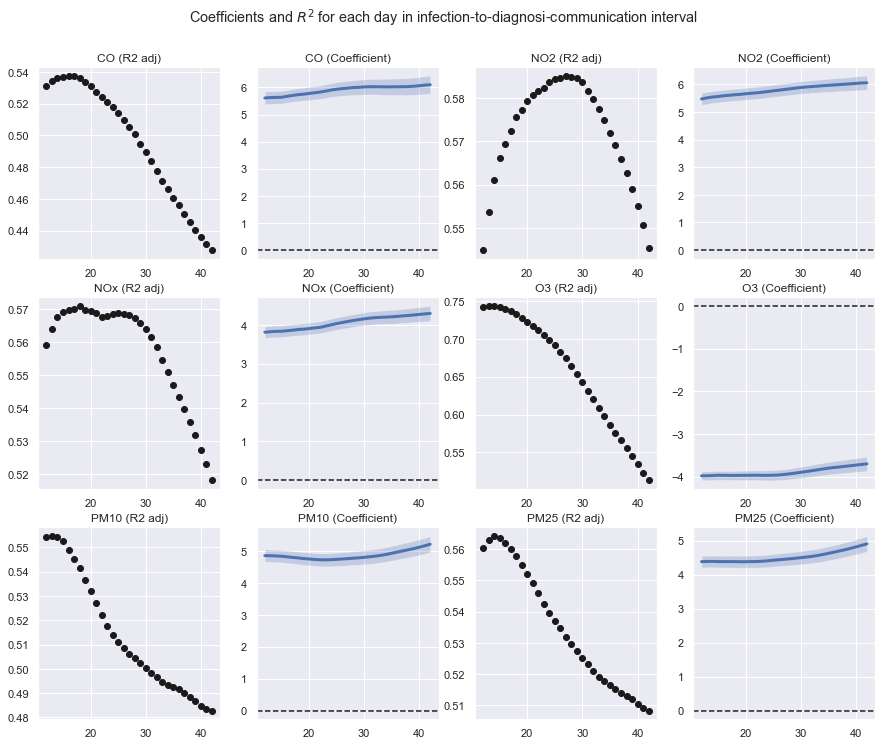

In [12]:
fig, axs = plt.subplots(3, 4, figsize=(15, 12))

for i, x in enumerate(sorted(res_df.x.unique())):
    ax0 = axs.flat[i*2]
    ax1 = axs.flat[i*2+1]
    _df = res_df[res_df.x==x]
    
    _df.plot(
        x='shift', y='R2_adj', title=f"{x} (R2 adj)", marker='o', ls='none', color='k', ax=ax0, legend=False,
        #xlabel='days from infection to diagnosis communication',
        xlabel=''
    )
    _df.plot(
        x='shift', y='coeff', color='b', lw=3, ax=ax1, title=f"{x} (Coefficient)", legend=False,
        #xlabel='days from infection to diagnosis communication'
        xlabel=''
    )
    ax1.fill_between(
        _df['shift'],
        _df.lo, _df.hi,
        alpha=.25
    )
    ax1.axhline(0, color='k', ls='--')
fig.suptitle('Coefficients and $R^2$ for each day in infection-to-diagnosi-communication interval', y=.95)
fig.savefig(f"images/coefficients_R2.png")
plt.show()

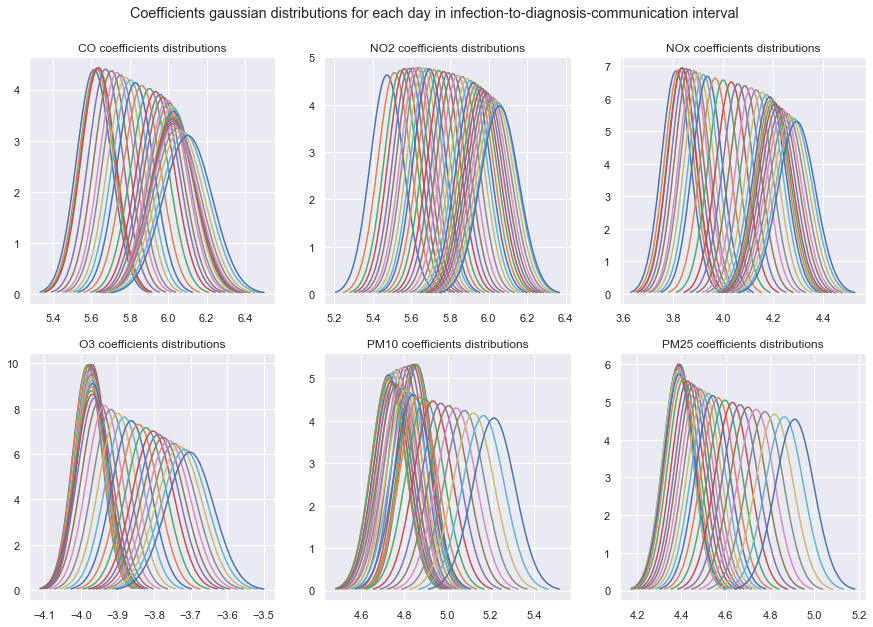

In [13]:
coeff_samples = {
    'x': [],
    'val': [],
}

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
for i, x in enumerate(res_df.x.unique()):
    ax = axs.flat[i]
    _df = res_df[res_df.x==x]
    
    for sh in _df['shift'].unique():
        __df = _df[_df['shift']==sh]
        
        loc = __df.coeff.values[0]
        scale = __df.standard_error.values[0]
        dist = sps.norm(loc=loc, scale=scale)
        
        dx = np.linspace(dist.ppf(.001), dist.ppf(.999))
        dy = dist.pdf(dx)
        ax.plot(dx, dy)
        
        sample = dist.rvs(10000)
        coeff_samples['x'] = np.concatenate((coeff_samples['x'], np.repeat(x, 10000)))
        coeff_samples['val'] = np.concatenate((coeff_samples['val'], sample))
    ax.set(
        title=f"{x} coefficients distributions",
        xlabel=''
    )
fig.suptitle(
    'Coefficients gaussian distributions for each day in infection-to-diagnosis-communication interval',
    y=.95
)
fig.savefig(f"images/distributions.png")
plt.show()

In [14]:
coeff_samples_df = pd.DataFrame(coeff_samples)

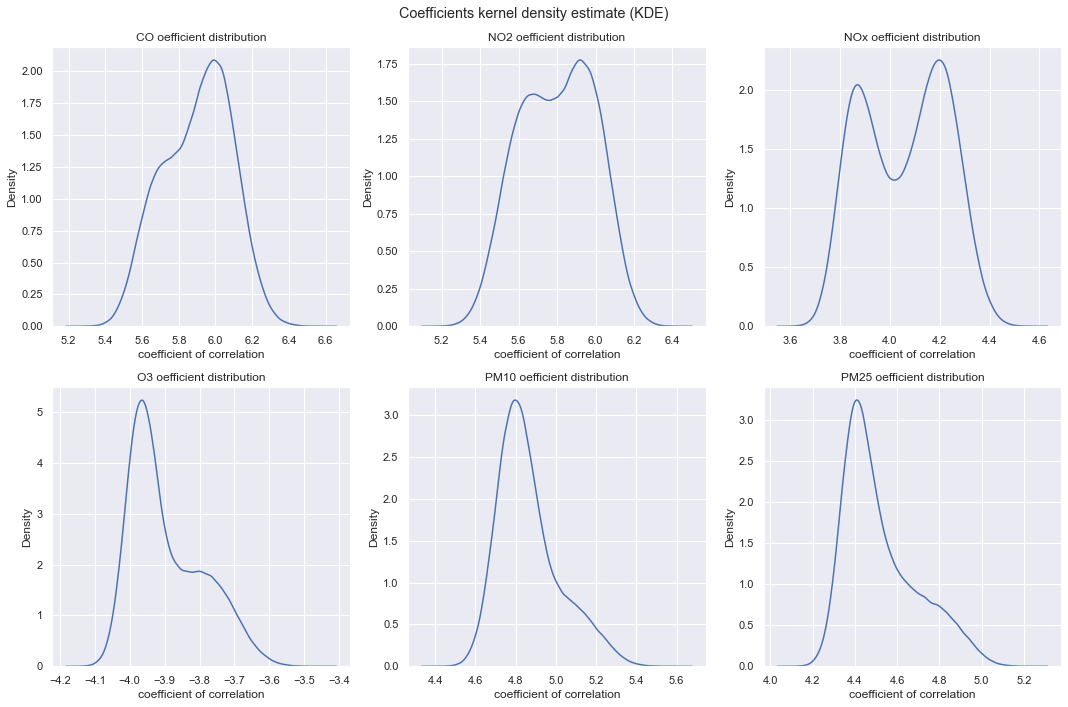

In [15]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
for i, x in enumerate(coeff_samples_df.x.unique()):
    ax = axs.flat[i]
    _df = coeff_samples_df[coeff_samples_df.x==x]
    g = sns.kdeplot(_df.val, ax=ax)
    ax.set(
        title=f"{x} oefficient distribution",
        xlabel='coefficient of correlation'
    )
fig.suptitle("Coefficients kernel density estimate (KDE)", y=.98)
fig.tight_layout()
fig.savefig(f"images/coefficients_distribution.png")
plt.show()

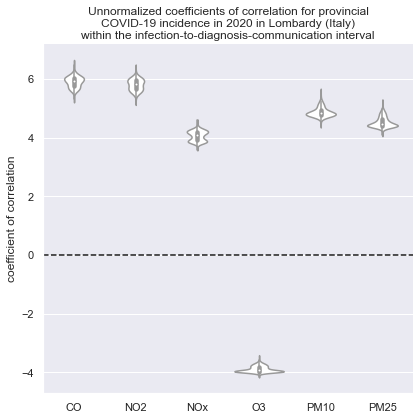

In [16]:
g = sns.catplot(
    kind='violin',
    data=coeff_samples_df,
    x='x', y='val',
    color='white', saturation=1,
    aspect=1, height=6,
)
ax = g.axes.flat[0]
ax.axhline(0, color='k', ls='--')
ax.set(
    ylabel='coefficient of correlation',
    xlabel=None,
    title="Unnormalized coefficients of correlation for provincial\n"
    "COVID-19 incidence in 2020 in Lombardy (Italy)\n"
    "within the infection-to-diagnosis-communication interval"
)
g.fig.tight_layout()
g.fig.savefig(f"images/coefficients_unnormalized.png")
plt.show()

In [17]:
std_devs = {
    'x': [],
    'std_dev': []
}
for x in cols:
    s = np.log(df[x]).std()
    std_devs['x'].append(x)
    std_devs['std_dev'].append(s)
std_devs = pd.DataFrame(std_devs).set_index('x')

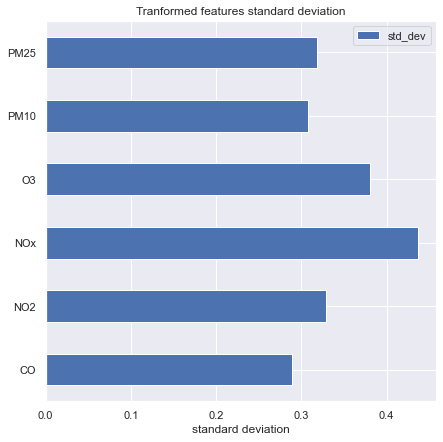

In [18]:
fig, ax = plt.subplots(figsize=(7, 7))
std_devs.plot(kind='barh', ax=ax)
ax.set(
    title='Tranformed features standard deviation',
    ylabel=None,
    xlabel='standard deviation'
)
fig.savefig('images/features_standard_deviation.png')
plt.show()

In [19]:
for x in coeff_samples_df.x.unique():
    _df = coeff_samples_df[coeff_samples_df.x==x]
    _s = std_devs.loc[x, 'std_dev']
    _n = _df.val * _s
    coeff_samples_df.loc[coeff_samples_df.x==x, 'normalized'] = _n.values

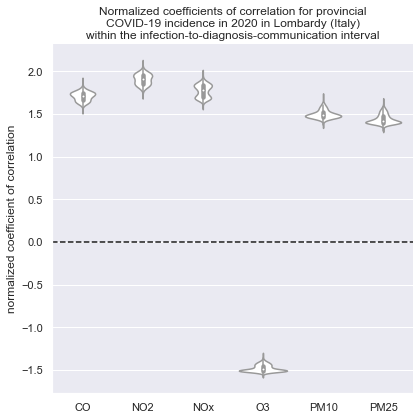

In [20]:
g = sns.catplot(
    kind='violin',
    data=coeff_samples_df,
    x='x', y='normalized',
    color='white', saturation=1,
    aspect=1, height=6,
)
ax = g.axes.flat[0]
ax.axhline(0, color='k', ls='--')
ax.set(
    ylabel='normalized coefficient of correlation',
    xlabel=None,
    title="Normalized coefficients of correlation for provincial\n"
    "COVID-19 incidence in 2020 in Lombardy (Italy)\n"
    "within the infection-to-diagnosis-communication interval"
)
g.fig.tight_layout()
g.fig.savefig(f"images/coefficients_normalized.png")
plt.show()

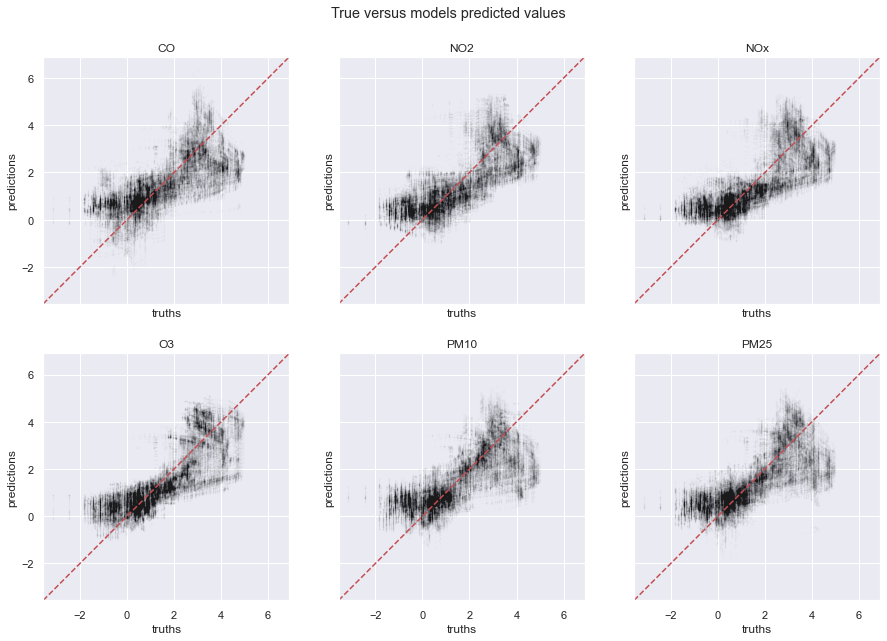

In [21]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)

for i, x in enumerate(res_df.x.unique()):
    _df = res_df[res_df.x==x]
    for s in _df['shift'].unique():
        __df = _df[_df['shift']==s]
        fit = __df.fit.values[0]
        truths = __df.y.values[0]
        predictions = fit.predict()
        ax.flat[i].plot(truths, predictions, marker='.', ms=1, color='k', ls='none', alpha=.01)
    _lim_min = np.min([ax.flat[i].get_xlim()[0], ax.flat[i].get_ylim()[0]])
    _lim_max = np.max([ax.flat[i].get_xlim()[1], ax.flat[i].get_ylim()[1]])
    ax.flat[i].axline(xy1=(_lim_min, _lim_min), slope=1, ls='--', color='r')
    ax.flat[i].set(
        xlim=(_lim_min, _lim_max),
        ylim=(_lim_min, _lim_max),
        title=x,
        xlabel='truths', ylabel='predictions'
    )
fig.suptitle('True versus models predicted values', y=.95)
fig.savefig('images/truths_predicted.png')
plt.show()

***